# Introduction

Here we want to replicate Sorscher et al.'s (2023) results of Grid cells arising from a path integrating RNN which predicts place cell outputs.

The model takes velocity inputs and predicts place cell output (velocity to place cell)
 - note that in order to encourage path integration within the RNN, for the first step in each trajectory
   the hidden activity of the RNN is set by an encoder from place cell activations.

In [68]:
## setup ##
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from importlib import reload
import matplotlib.pyplot as plt

# local imports #
from GridModels.code.RNNs import vel2pc_RNN as v2p


In [ ]:
# introduce a model #
print(v2p.options.__dict__)
model, dataset, losses = v2p.get_model_and_data(v2p.options) #will try to load a model if it exists, otherwise will train a new one


Using device: cuda
Using device: cuda
{'device': device(type='cuda'), 'save_dir': '../code/GridModels/data/sorscher_models/', 'n_steps': 100000, 'batch_size': 200, 'sequence_length': 20, 'n_epochs': 100, 'train_ratio': 0.8, 'environment_scale': 1.5, 'framerate': 0.016666666666666666, 'learning_rate': 0.0001, 'Ng': 4096, 'Np': 512, 'place_cell_rf': 0.15, 'pc_type': 'diff_of_gaussians', 'RNN_type': 'RNN', 'activation': 'relu', 'weight_decay': 1e-06}
Loading existing model and data!
failed to load dataset: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `wei

<Axes: >

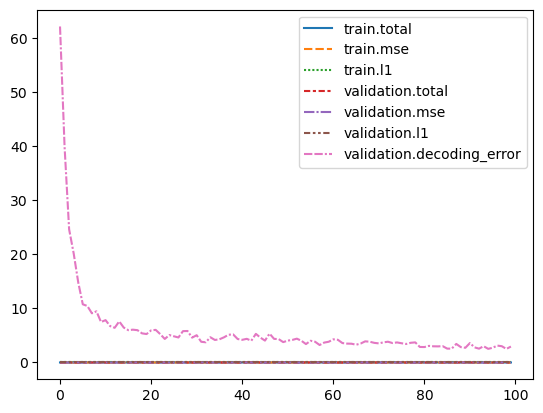

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(losses)

In [23]:
nav_rates_df = v2p.generate_navigation_rates_df(v2p.options)
new_dataset = v2p.vel2pc_dataset(v2p.options, navigation_rates_df = nav_rates_df)

Using device: cuda


100%|██████████| 100000/100000 [01:27<00:00, 1141.84it/s]


In [123]:
reload(v2p)
pc_nav_rates_df, hidden_activity_df, predicted_pc_df = v2p.generate_hidden_activity(model,v2p.options)

Using device: cuda
Using device: cuda
generating trajectory


100%|██████████| 100000/100000 [01:24<00:00, 1180.42it/s]


generating hidden activity


100%|██████████| 100000/100000 [00:58<00:00, 1710.08it/s]


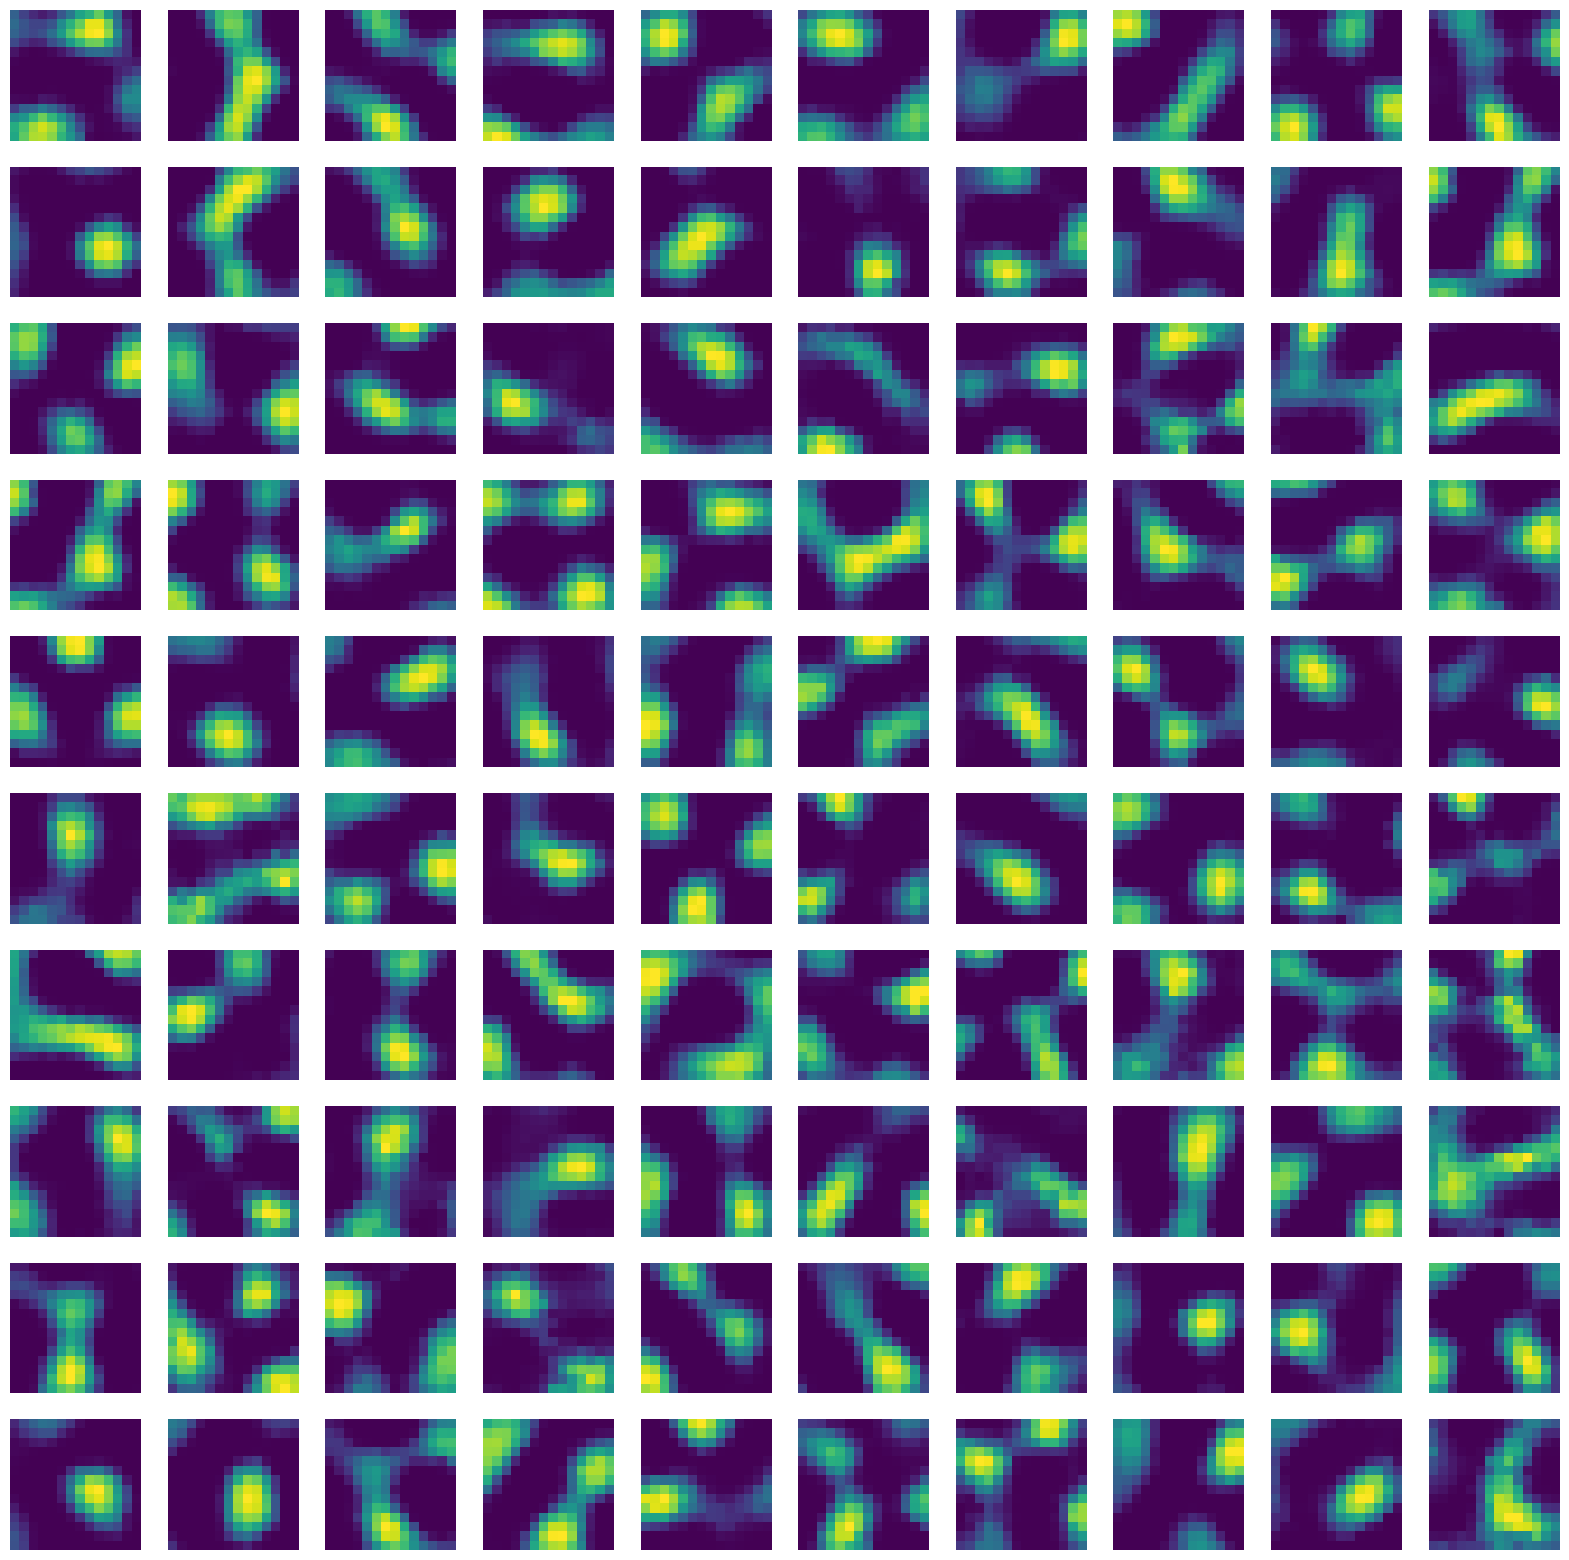

In [187]:
from GridMaze.analysis.cluster_tuning import spatial

rates = hidden_activity_df.firingrate.values
rates[rates<0] = 0 #rectified linear activations
positions = pc_nav_rates_df.centroid_position.values
ratemaps, binx, biny = spatial.get_2D_ratemaps(rates,positions,
                                               x_size = 0.10,
                                               y_size = 0.10,
                                               smooth_SD = 0)

# let's plot a 10x10 panel of 100 random neurons
rng = np.random.default_rng(42)  # Use any integer you like
random_integers = rng.integers(0, options.Ng+1, size=100) 
fig, ax = plt.subplots(10,10, figsize = (20,20))
for i, each_unit in enumerate(random_integers):
    ax.flatten()[i].imshow(ratemaps[each_unit],origin='lower')
    ax.flatten()[i].axis('off')

In [ ]:
# now we can look for grid cell models using the UMAP method:



array([ 365, 3170, 2681, 1798, 1774, 3517,  352, 2857,  825,  385, 2156,
       3997, 3014, 3118, 2939, 3220, 2102,  524, 3440, 1845, 2049, 1519,
        747, 3796, 3202, 2637, 1648, 3370, 2234, 1816, 1845,  930,  377,
       2272, 3637,  261, 3516, 3390, 1133, 2587,  676, 3105, 2870, 1452,
        278, 3976, 1825, 3659, 2777, 3189, 3113,  797, 1490, 1912, 2039,
        179, 2239,  632, 3045, 2798, 3779, 3051, 1502, 3963, 1683, 1334,
       3709, 1517,  312, 1923, 3259,  776, 1896,  532, 2812, 1948, 1352,
        929, 2312, 2744, 3852, 1791,  658, 3411, 2580, 2868,  398, 1279,
       3145, 3409, 1783, 3297, 3448, 1587, 3679, 1181,  981, 2796, 2608,
        572])

/nfs/nhome/live/cburns/.conda/envs/GridMaze/lib/python3.10/importlib/__init__.py:169: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)


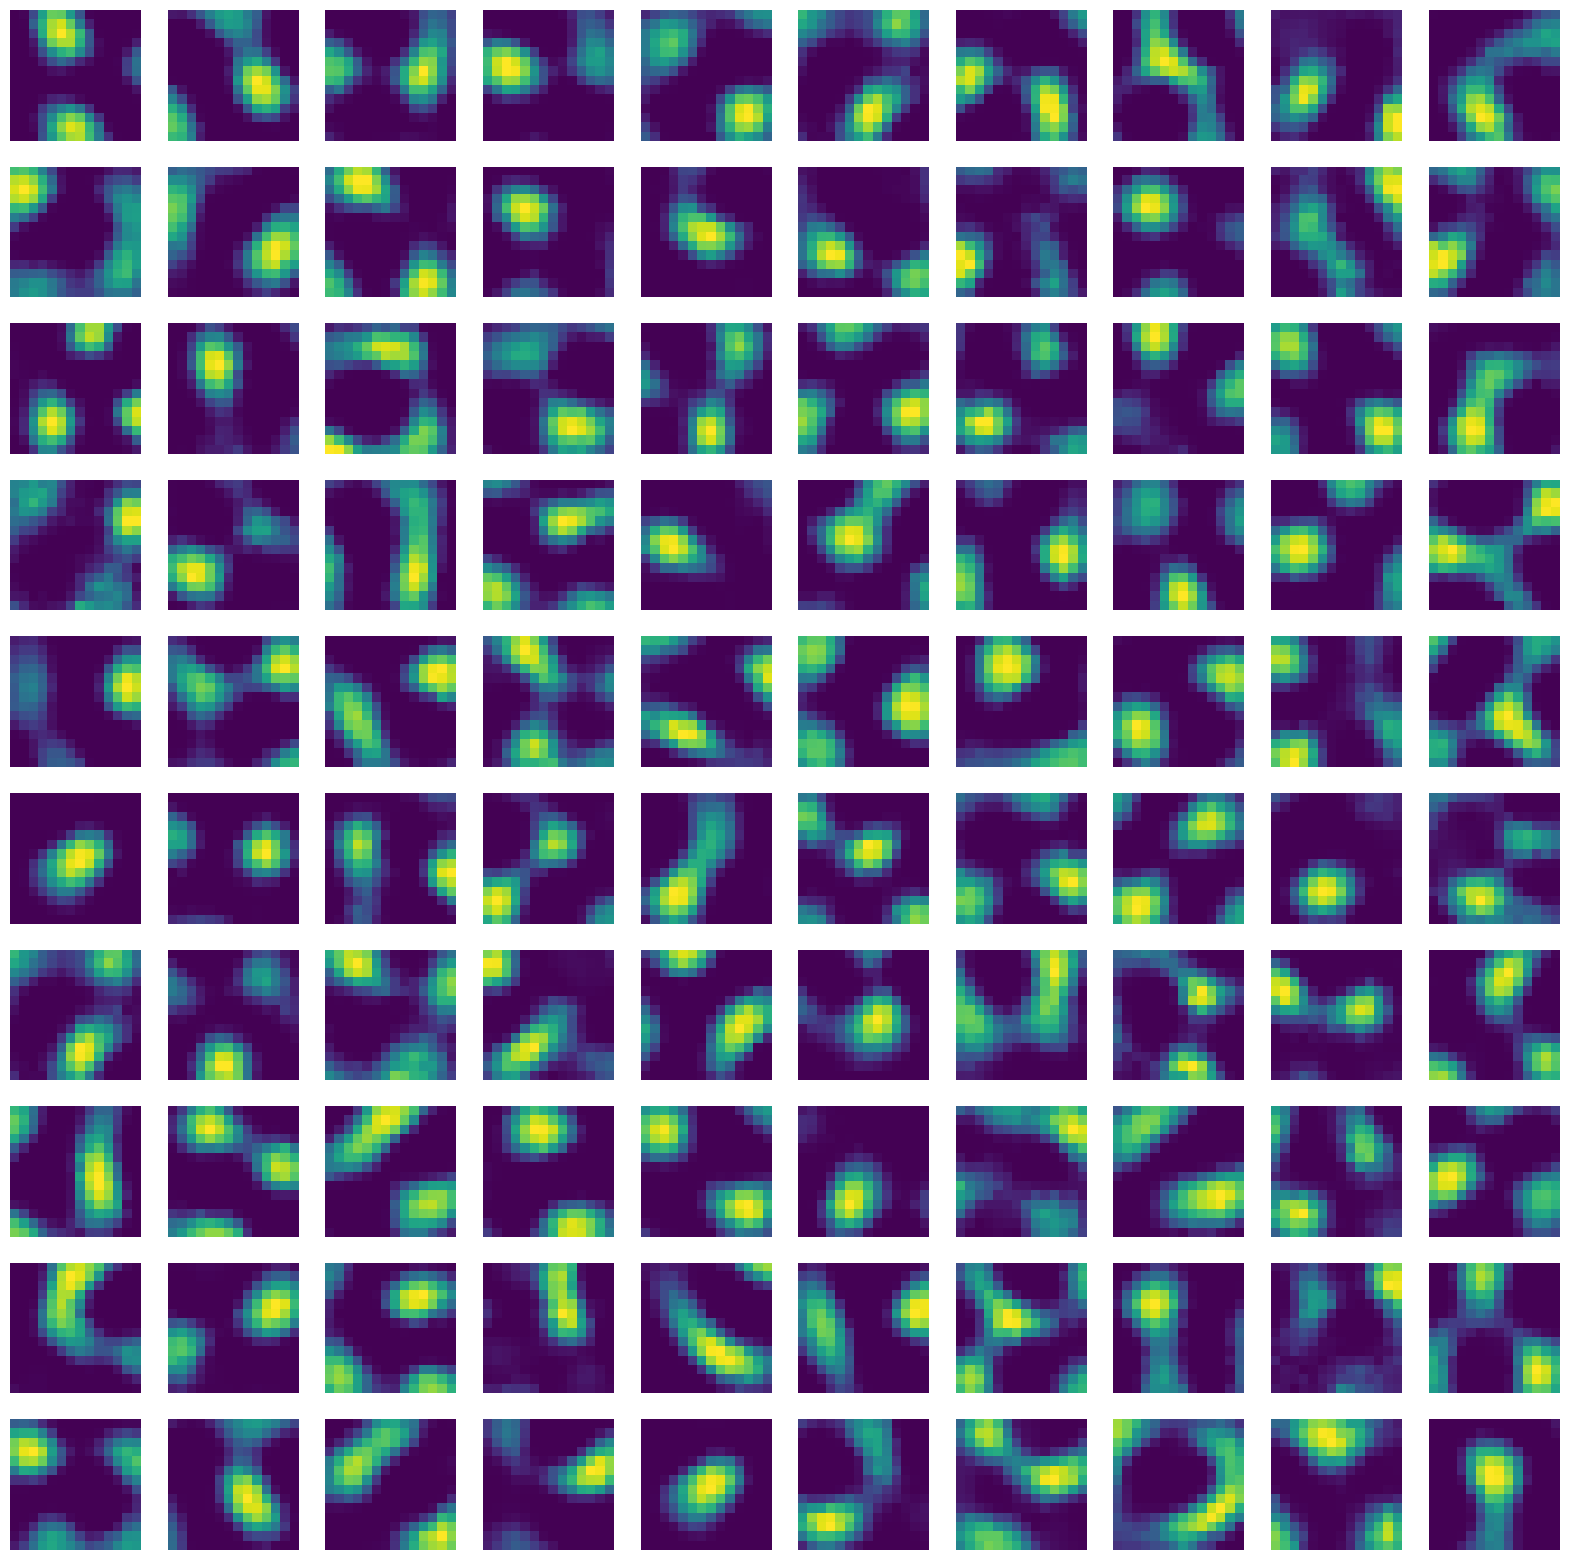

In [ ]:
reload(np)
